In [1]:
%%capture
import numpy as np
from functools import reduce
import time
%run commute.ipynb
%run diagonalize.ipynb
%run phase.ipynb
%run QDrift.ipynb
%run hamiltonian.ipynb

In [2]:
def Simulation_cost(Chs, CPs):
    """ Returns the cost of the simulation,
    total costs, individual costs in [crzs, toffolis]
    """
    crzs, Toffolis = 0, 0
    icosts = []
    n = len(CPs[0][0])
    for Ch, CP in zip(Chs, CPs):
        _, CZ, _ = diag_results(CP, True)
        _, _, cost = logic_min(CZ, Ch)
        crzs += cost[0]
        Toffolis += cost[1]
        icosts.append([cost[0], cost[1]])
    tcost = [crzs, Toffolis]
    return np.array(tcost), np.array(icosts)

def Hs_sum(CHs, Chs):
    """ Regroups the cliques according to coefficients
    """
    tolerance = 1e-3
    SHs, Shs = [], []
    for CH, Ch in zip(CHs, Chs):
        SH, Sh = [], []
        idx = np.argsort(Ch)
        sCH, sCh = np.array(CH)[idx][::-1], np.array(Ch)[idx][::-1]
        while len(sCh) > 0:
            if np.abs(sCh[0]) < tolerance:
                break
            Sh.append(sCh[0])
            SH.append(np.sum(sCH, axis=0))
            sCh = sCh - sCh[0]
            cut = (-1*tolerance > sCh) | (sCh > tolerance)
            sCh = sCh[cut]
            sCH = sCH[cut]
        SHs.append(SH); Shs.append(Sh) 
    return SHs, Shs

def Hs_sum_costs(SHs, Shs, icosts):
    Hs_s, hs_s, costs = [], [], []
    for SH, Sh, icost in zip(SHs, Shs, icosts):
        for H, h in zip(SH, Sh):
            Hs_s.append(H); hs_s.append(h), costs.append(icost)
    return np.array(Hs_s), np.array(hs_s), costs



In [3]:
geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 1))]
basis = "sto-3g"
multiplicity = 1
charge = 0

n, Hm, Hs, hs, Ps = Paulis_from_Molecule(None, geometry, basis, multiplicity, charge)



terms = list(zip(Hs, hs, Ps))
terms1 = [list(term) for term in terms]
terms = np.array(terms1, dtype=object)

# Reorder 
terms[[5,9]] = terms[[9,5]]
terms[[10,14]] = terms[[14,10]]
terms[[9,10]] = terms[[10,9]]

# Z
terms[3][:2], terms[4][:2] = -terms[3][:2], -terms[4][:2]
terms[3][2], terms[4][2] = '-'+terms[3][2], '-'+terms[4][2]
# terms[1:5, 1] = np.mean(terms[1:5, 1])

# XY
terms[7][:2], terms[8][:2] = -terms[7][:2], -terms[8][:2]
terms[7][2], terms[8][2] = '-'+terms[7][2], '-'+terms[8][2]

# ZZ
# terms[9:13, 1] = np.mean(terms[9:13, 1])

for i, term in enumerate(terms):
    print(i, term[1:])

def get_clique(i, j):
    return np.sum(np.stack(terms[i:j][:, 0]), axis=0)

SI = get_clique(0,1)
SZ0 = get_clique(1,3)
SZ1 = get_clique(1,5)
SXY = get_clique(5,9)
SZZ0 = get_clique(9,10)
SZZ1 = get_clique(10,11)
SZZ2 = get_clique(9,13)
SZZ3 = get_clique(13,15)

Hs_s = np.array([SZ0, SZ1, SXY, SZZ0, SZZ1, SZZ2, SZZ3])
hs_s = np.array([terms[1][1]-terms[3][1], terms[3][1], terms[5][1], terms[9][1]-terms[11][1], terms[10][1]-terms[11][1], terms[11][1], terms[13][1]])
icosts = np.array([[2,2], [2,2], [1,3], [1,1], [1,1], [1,1], [1,2]])
Hs, hs = Hs[1:], hs[1:]

# Hs_s, hs_s, icosts = Hs_sum_costs(SHs, Shs, icosts)

0 [-0.3276081896748093 'IIII']
1 [0.13716572937099508 'ZIII']
2 [0.13716572937099503 'IZII']
3 [0.13036292057109106 '-IIZI']
4 [0.13036292057109106 '-IIIZ']
5 [0.04919764587136755 'XYYX']
6 [0.04919764587136755 'YXXY']
7 [0.04919764587136755 '-YYXX']
8 [0.04919764587136755 '-XXYY']
9 [0.16326768673564346 'IIZZ']
10 [0.15660062488237947 'ZZII']
11 [0.15542669077992832 'ZIIZ']
12 [0.15542669077992832 'IZZI']
13 [0.10622904490856075 'IZIZ']
14 [0.10622904490856075 'ZIZI']


In [4]:
t = 2
M = 14

rho = rand_rho(n)
Ns = [2**i + 10 for i in range(5, M)]
st = time.time()

# print(time.time()-st)
errors_costs = np.array([Error_cost(Hm, Hs_s, hs_s, t, rho, N, icosts, threads=12) for N in Ns])
errors_costs1 = np.array([Error_cost(Hm, Hs, hs, t, rho, N, threads=12) for N in Ns])
errors, errors1 = errors_costs[:, 0], errors_costs1[:, 0]
tcosts, rcosts = errors_costs[:, 1], errors_costs[:, 2]

Running N=8202: 100%|██████████| 100/100 [1:03:21<00:00, 38.39s/it]


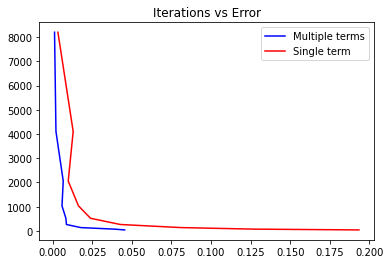

In [5]:
plt.title('Iterations vs Error')
plt.plot(errors, Ns, 'b-', label='Multiple terms', markersize=3)
plt.plot(errors1, Ns, 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

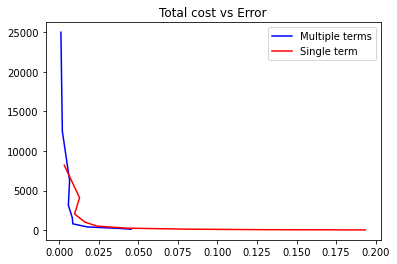

In [6]:
plt.title('Total cost vs Error')
plt.plot(errors, tcosts, 'b-', label='Multiple terms', markersize=3)
plt.plot(errors1, Ns, 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

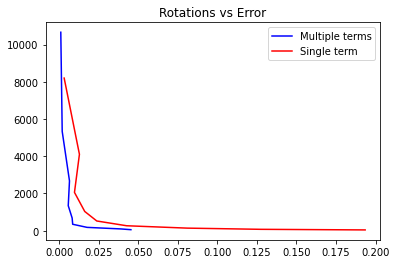

In [7]:
plt.title('Rotations vs Error')
plt.plot(errors, rcosts, 'b-', label='Multiple terms', markersize=3)
plt.plot(errors1, Ns, 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

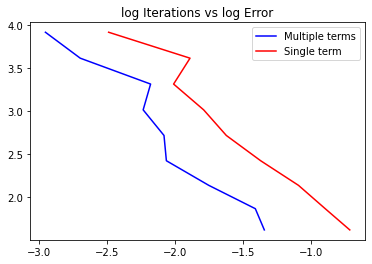

In [8]:
plt.title('log Iterations vs log Error')
plt.plot(np.log10(errors), np.log10(Ns), 'b-', label='Multiple terms', markersize=3)
plt.plot(np.log10(errors1), np.log10(Ns), 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

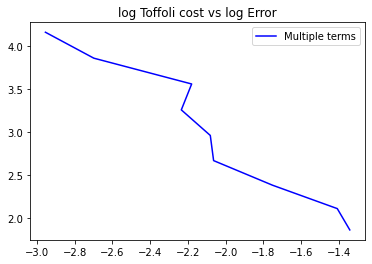

In [9]:
toffcost = tcosts - rcosts

plt.title('log Toffoli cost vs log Error')
plt.plot(np.log10(errors), np.log10(toffcost), 'b-', label='Multiple terms', markersize=3)
plt.legend()
plt.show()

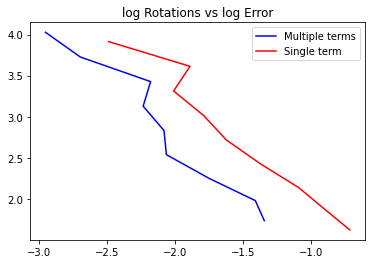

In [10]:
plt.title('log Rotations vs log Error')
plt.plot(np.log10(errors), np.log10(rcosts), 'b-', label='Multiple terms', markersize=3)
plt.plot(np.log10(errors1), np.log10(Ns), 'r-', label='Single term', markersize=3)
plt.legend()
plt.show()

In [11]:
print(errors1[-1], errors[-1])

0.0032409233774959426 0.0011095783618337708


In [12]:
# np.savetxt('rcosts', rcosts)
# np.savetxt('tcosts', tcosts)
# np.savetxt('errors', errors)
# np.savetxt('errors1', errors1)
# np.savetxt('Ns', Ns)